In [18]:
!pip install torch torchvision tqdm

In [52]:
pwd

'/home/np1140/ML Robust/Q1.1'

In [53]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(123)

In [54]:
# Load MNIST dataset as tensors using DataLoader class
batch_size = 128
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

def tensor_to_images(image_tensor,epoch = 0, num_images=30, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.savefig('output/op' + str(epoch) + '.png')
    plt.show()

In [55]:
sample_img = next(iter(dataloader))

In [56]:
print(dataloader.dataset)
print(len(dataloader))

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()
469


In [57]:
sample_img[0].shape

torch.Size([128, 1, 28, 28])

In [58]:
sample_img[-1][0:30]

tensor([6, 8, 4, 8, 2, 8, 0, 6, 6, 0, 9, 5, 2, 7, 1, 8, 1, 1, 4, 6, 1, 2, 6, 0,
        7, 5, 3, 4, 8, 9])

In [59]:
# tensor_to_images(sample_img[0])

In [60]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=10, image_dimension=784, hidden_dimension=128):
        super(Generator, self).__init__()

        self.n_dim = noise_dimension
        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        # Build the generator network
        self.gen = nn.Sequential(
            self.generator_block(self.n_dim, self.h_dim),
            self.generator_block(self.h_dim, self.h_dim * 2),
            self.generator_block(self.h_dim * 2, self.h_dim * 4),
            self.generator_block(self.h_dim * 4, self.h_dim * 8),
            nn.Linear(self.h_dim * 8, self.im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    def generator_block(self, in_dimension, out_dimension):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.BatchNorm1d(out_dimension),
            nn.ReLU(inplace=True),
        )

In [61]:
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension,device=device)

In [62]:
torch.rand(5, 6, device = 'cpu')

tensor([[0.0740, 0.8665, 0.1366, 0.1025, 0.1841, 0.7264],
        [0.3153, 0.6871, 0.0756, 0.1966, 0.3164, 0.4017],
        [0.1186, 0.8274, 0.3821, 0.6605, 0.8536, 0.5932],
        [0.6367, 0.9826, 0.2745, 0.6584, 0.2775, 0.8573],
        [0.8993, 0.0390, 0.9268, 0.7388, 0.7179, 0.7058]])

In [63]:
class Discriminator(nn.Module):
    def __init__(self, image_dimension=784, hidden_dimension=128):
        super(Discriminator, self).__init__()

        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        self.disc = nn.Sequential(
            self.discriminator_block(self.im_dim, self.h_dim * 4),
            self.discriminator_block(self.h_dim * 4, self.h_dim * 2),
            self.discriminator_block(self.h_dim * 2, self.h_dim),
            nn.Linear(self.h_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )

In [64]:
# Hyperparameters for training loop
criterion = nn.BCEWithLogitsLoss()
n_epochs = 101
noise_dimension = 64
display_step = 5000
lr = 0.00001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [66]:
print(disc)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [67]:
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # All of them will got label as 0
    # .detach() here is to ensure that only discriminator parameters will get update
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred,
                               torch.zeros_like(disc_fake_pred))

    # Pass real features to discriminator
    # All of them will got label as 1
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred,
                               torch.ones_like(disc_real_pred))

    # Average of loss from both real and fake features
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

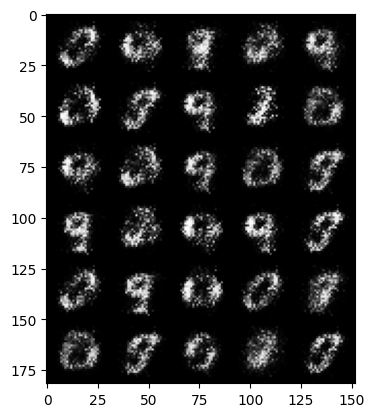

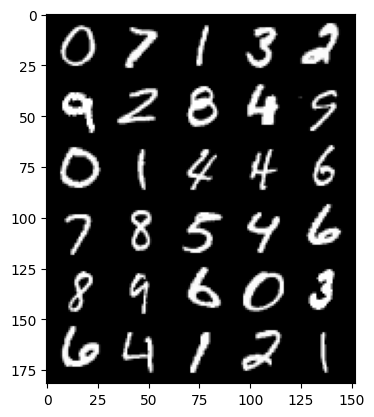

Epoch 10: Generator loss: 3.7909278869628906, discriminator loss: 0.07888590544462204


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

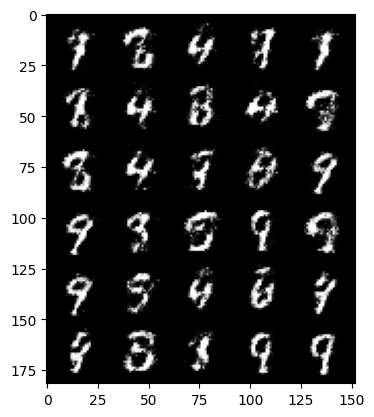

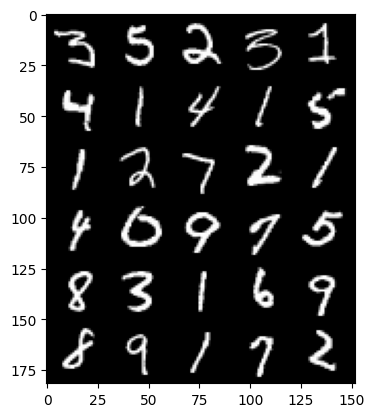

Epoch 50: Generator loss: 2.93469500541687, discriminator loss: 0.12357266247272491


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

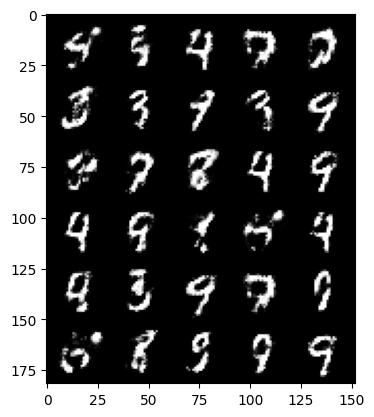

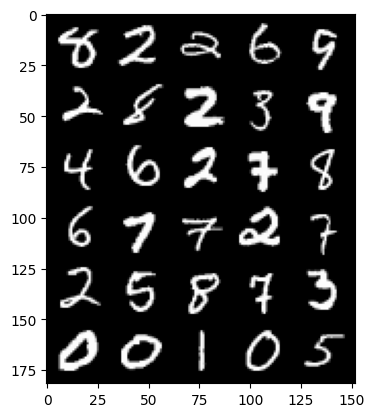

Epoch 100: Generator loss: 1.8272943496704102, discriminator loss: 0.3749581575393677


In [68]:
import csv

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):

        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()


        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()
        
    
    if epoch == 10 or epoch == 50 or epoch == 100:
        fake_noise = get_noise(cur_batch_size, noise_dimension, device=device)
        fake = gen(fake_noise)
        tensor_to_images(fake, epoch)
        tensor_to_images(real, epoch)
        print(f"Epoch {epoch}: Generator loss: {gen_loss}, discriminator loss: {disc_loss}")

    cur_step += 1
    with open('losses.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([gen_loss.item(), disc_loss.item()])

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

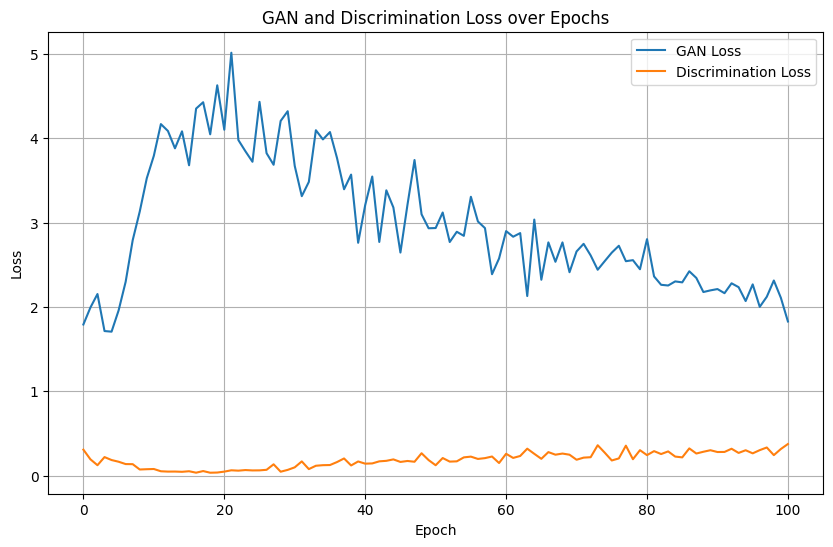

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('losses.csv')  


gan_loss = data['GAN loss']
discrimination_loss = data['Discrimination loss']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gan_loss, label='GAN Loss')
plt.plot(discrimination_loss, label='Discrimination Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN and Discrimination Loss over Epochs')
plt.legend()
plt.grid()
# plt.save('output/plot.png')
plt.show()


In [72]:
pwd

'/home/np1140/ML Robust/Q1.1'